## <b>PART 4: Ligand-based screening (Compound Similarity)</b>

In [81]:
# Import relevant Python packages
# The majority of the basic molecular functionality is found in module rdkit.Chem
from rdkit import Chem
# Drawing related
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs

import math
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt

In [82]:
# Import data from csv file containing compounds in SMILES format
filtered_df = pd.read_csv('GSKmol_compounds_lipinski.csv', delimiter=';', usecols=['molecule_chembl_id', 'smiles', 'pIC50'])
filtered_df.head()

,molecule_chembl_id,smiles,pIC50
0,CHEMBL3701767,CC1(O)CC(N)(C1)c2ccc(cc2)c3nc4c5cc(ccc5OCn4c3c...,9.585027
1,CHEMBL3701766,CNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)C...,9.552842
2,CHEMBL3701717,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(F)cccc6O...,9.537602
3,CHEMBL3701737,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(Cl)cccc6...,9.522879
4,CHEMBL3701769,CCNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)...,9.508638


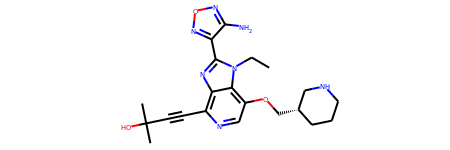

In [83]:
# Generate Mol object from SMILES of query compound
query = Chem.MolFromSmiles('CCn1c(nc2c(ncc(OC[C@H]3CCCNC3)c12)C#CC(C)(C)O)c4nonc4N');  # GSK-690693
query

In [84]:
# Generate MACCS and Morgan fingerprints for query compound
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)
circ_fp_query = rdFingerprintGenerator.GetCountFPs([query])[0]

In [85]:
# Generate MACCS and Morgan fingerprints for all molecules in file
ms = [Chem.MolFromSmiles(i) for i in filtered_df.smiles]
circ_fp_list = rdFingerprintGenerator.GetCountFPs(ms)
maccs_fp_list = [MACCSkeys.GenMACCSKeys(m) for m in ms]

In [86]:
# Calculate Tanimoto similarity for query compound (GSK-690693) and all molecules in file (MACCS, Morgan)
tanimoto_maccs = DataStructs.BulkTanimotoSimilarity(maccs_fp_query,maccs_fp_list)
tanimoto_circ = DataStructs.BulkTanimotoSimilarity(circ_fp_query,circ_fp_list)

In [87]:
# Calculate Dice similarity for query compound (GSK-690693) and all molecules in file (MACCS, Morgan)
dice_maccs = DataStructs.BulkDiceSimilarity(maccs_fp_query,maccs_fp_list)
dice_circ = DataStructs.BulkDiceSimilarity(circ_fp_query,circ_fp_list)

In [88]:
# Make table with ChEMLB ID, SMILES and Tanimoto similarity of the compounds to GSK-690693
similarity_df = pd.DataFrame({'ChEMBL_ID':filtered_df.molecule_chembl_id,
                              'bioactivity':filtered_df.pIC50,
                              'tanimoto_MACCS': tanimoto_maccs, 
                              'tanimoto_morgan': tanimoto_circ, 
                              'dice_MACCS': dice_maccs,
                              'dice_morgan': dice_circ,
                              'smiles': filtered_df.smiles,})

In [89]:
# Show DataFrame
similarity_df.head()

,ChEMBL_ID,bioactivity,tanimoto_MACCS,tanimoto_morgan,dice_MACCS,dice_morgan,smiles
0,CHEMBL3701767,9.585027,0.607143,0.140244,0.755556,0.245989,CC1(O)CC(N)(C1)c2ccc(cc2)c3nc4c5cc(ccc5OCn4c3c...
1,CHEMBL3701766,9.552842,0.611765,0.144578,0.759124,0.252632,CNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)C...
2,CHEMBL3701717,9.537602,0.616279,0.146341,0.762590,0.255319,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(F)cccc6O...
3,CHEMBL3701737,9.522879,0.616279,0.146341,0.762590,0.255319,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(Cl)cccc6...
4,CHEMBL3701769,9.508638,0.666667,0.155689,0.800000,0.269430,CCNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)...


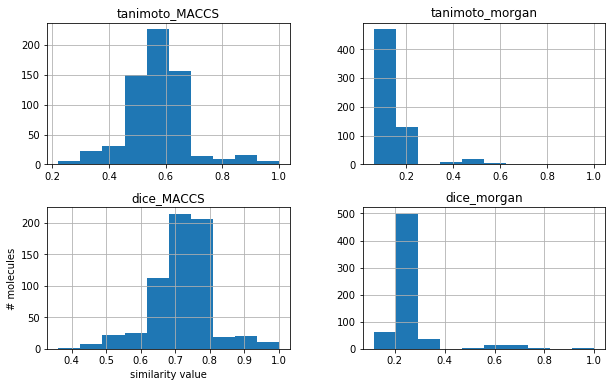

In [90]:
# Plot distribution of Tanimoto similarity of MACCS fingerprints
%matplotlib inline
fig, axes = plt.subplots(figsize=(10,6), nrows=2, ncols=2)
similarity_df.hist(["tanimoto_MACCS"], ax=axes[0,0])
similarity_df.hist(["tanimoto_morgan"], ax=axes[0,1])
similarity_df.hist(["dice_MACCS"], ax=axes[1,0])
similarity_df.hist(["dice_morgan"], ax=axes[1,1])
axes[1,0].set_xlabel("similarity value")
axes[1,0].set_ylabel("# molecules")
plt.show()

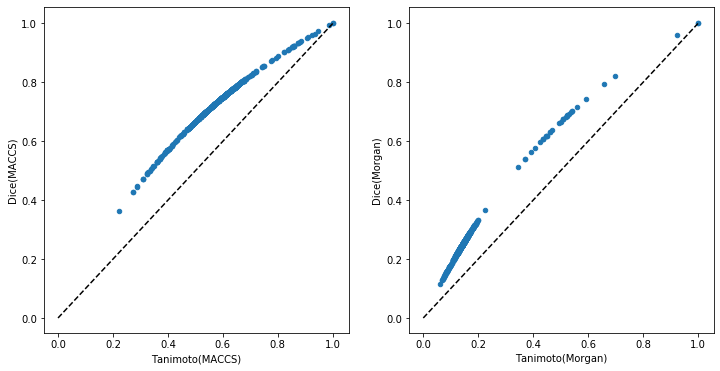

In [91]:
fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=2)

similarity_df.plot('tanimoto_MACCS','dice_MACCS',kind='scatter',ax=axes[0])
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_xlabel("Tanimoto(MACCS)")
axes[0].set_ylabel("Dice(MACCS)")

similarity_df.plot('tanimoto_morgan','dice_morgan',kind='scatter',ax=axes[1])
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_xlabel("Tanimoto(Morgan)")
axes[1].set_ylabel("Dice(Morgan)")

plt.show()

In [92]:
# Sort DataFrame by tanimoto_morgan
similarity_df.sort_values(['tanimoto_morgan'], ascending=False, inplace=True)
similarity_df.head()

,ChEMBL_ID,bioactivity,tanimoto_MACCS,tanimoto_morgan,dice_MACCS,dice_morgan,smiles
149,CHEMBL494089,7.886057,1.000000,1.000000,1.000000,1.000000,CCn1c(nc2c(ncc(OC[C@H]3CCCNC3)c12)C#CC(C)(C)O)...
147,CHEMBL521642,7.886057,1.000000,1.000000,1.000000,1.000000,CCn1c(nc2c(ncc(OC[C@@H]3CCCNC3)c12)C#CC(C)(C)O...
148,CHEMBL494088,7.886057,0.986667,0.922222,0.993289,0.959538,CCn1c(nc2c(ncc(OCC3CCNC3)c12)C#CC(C)(C)O)c4nonc4N
186,CHEMBL453510,7.698970,0.907895,0.697917,0.951724,0.822086,CCn1c(nc2c(ncc(OCCN)c12)C#CC(C)(C)O)c3nonc3N
119,CHEMBL493269,8.045757,0.947368,0.656863,0.972973,0.792899,CCn1c(nc2c(ncc(OCCCCN)c12)C#CC(C)(C)O)c3nonc3N


In [93]:
# Add a structural representation of the SMILES strings (ROMol - RDKit object Mol) to the DataFrame
PandasTools.AddMoleculeColumnToFrame(similarity_df, 'smiles')

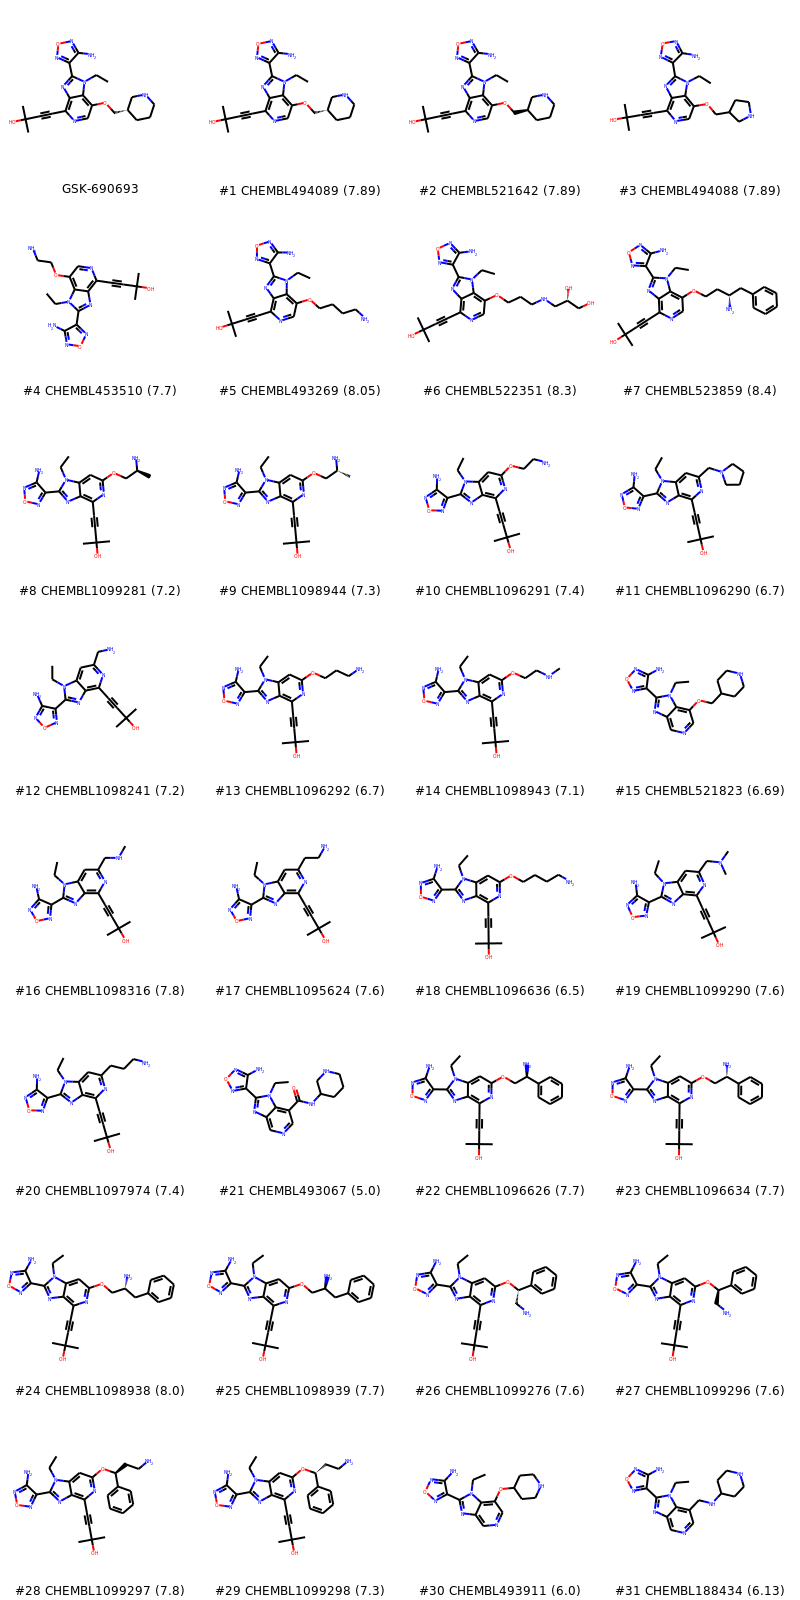

In [98]:
# Draw query and top molecules (+ bioactivity data)
sim_mols = [Chem.MolFromSmiles(i) for i in similarity_df.smiles][:31]

legend = ['#' + str(a) + ' ' + b + ' ('+str(round(c,2))+')' for a, b, c in zip(range(1,len(sim_mols)+1),
                                                                               similarity_df.ChEMBL_ID, 
                                                                               similarity_df.bioactivity)]
Chem.Draw.MolsToGridImage(mols = [query] + sim_mols[:31], 
                          legends = (['GSK-690693'] + legend), 
                          molsPerRow = 4)

In [99]:
# pIC50 cut-off value used to discriminate active and inactive compounds
threshold = 6.3

,ChEMBL_ID,bioactivity,tanimoto_MACCS,tanimoto_morgan,dice_MACCS,dice_morgan,smiles,ROMol
149,CHEMBL494089,7.886057,1.000000,1.000000,1.000000,1.000000,CCn1c(nc2c(ncc(OC[C@H]3CCCNC3)c12)C#CC(C)(C)O)...,
147,CHEMBL521642,7.886057,1.000000,1.000000,1.000000,1.000000,CCn1c(nc2c(ncc(OC[C@@H]3CCCNC3)c12)C#CC(C)(C)O...,
148,CHEMBL494088,7.886057,0.986667,0.922222,0.993289,0.959538,CCn1c(nc2c(ncc(OCC3CCNC3)c12)C#CC(C)(C)O)c4nonc4N,
186,CHEMBL453510,7.698970,0.907895,0.697917,0.951724,0.822086,CCn1c(nc2c(ncc(OCCN)c12)C#CC(C)(C)O)c3nonc3N,
119,CHEMBL493269,8.045757,0.947368,0.656863,0.972973,0.792899,CCn1c(nc2c(ncc(OCCCCN)c12)C#CC(C)(C)O)c3nonc3N,

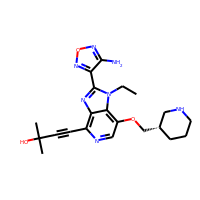
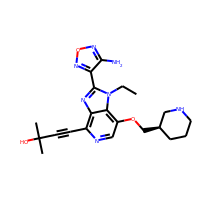
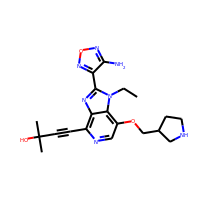
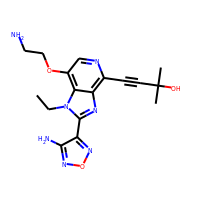
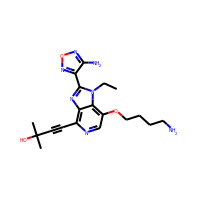

In [100]:
similarity_df.head()

In [101]:
def get_enrichment_data(similarity_df, similarity_measure, threshold):
    """
    This function calculates x and y values for enrichment plot:
    x - % ranked dataset
    y - % true actives identified
    """
    
    # Get number of molecules in data set
    mols_all = len(similarity_df)
    
    # Get number of active compounds in data set
    actives_all = sum(similarity_df.bioactivity >= threshold)

    # Initialize a list that will hold the counter for actives and compounds while iterating through our dataset
    actives_counter_list = []
    
    # Initialize counter for actives
    actives_counter = 0
    
    # Note: Data must be ranked for enrichment plots:
    # Sort compounds by selected similarity measure
    similarity_df.sort_values([similarity_measure], ascending=False, inplace=True)

    # Iterate over the ranked dataset and check each compound if active (by checking bioactivity)
    for value in similarity_df.bioactivity:
        if value >= threshold:
            actives_counter += 1
        actives_counter_list.append(actives_counter)

    # Transform number of molecules into % ranked dataset
    mols_perc_list = [i/mols_all for i in list(range(1, mols_all+1))]

    # Transform number of actives into % true actives identified
    actives_perc_list = [i/actives_all for i in actives_counter_list]

    # Generate DataFrame with x and y values as well as label 
    enrich_df = pd.DataFrame({'% ranked dataset':mols_perc_list, 
                              '% true actives identified':actives_perc_list,
                              'similarity_measure': similarity_measure})
    
    return enrich_df

In [102]:
# Define similarity measures to be plotted
sim_measures = ['tanimoto_MACCS', 'tanimoto_morgan']

# Generate a list of DataFrames containing all enrichment plot data for all similarity measures
enrich_data = [get_enrichment_data(similarity_df, i, threshold) for i in sim_measures]

In [103]:
# Prepare data set for plotting:
# Concatenate per-similarity measure DataFrames to one DataFrame
# - different similarity measures are still distinguishable by the "similarity_measure" column
enrich_df = pd.concat(enrich_data)

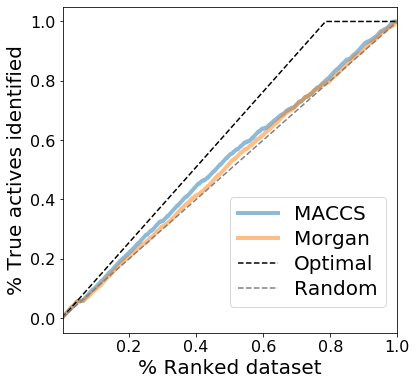

In [104]:
fig, ax = plt.subplots(figsize=(6, 6))

fontsize = 20

for key, grp in enrich_df.groupby(['similarity_measure']):
    ax = grp.plot(ax = ax,
                  x = '% ranked dataset',
                  y = '% true actives identified',
                  label=key,
                  alpha=0.5, linewidth=4)
ax.set_ylabel('% True actives identified', size=fontsize)
ax.set_xlabel('% Ranked dataset', size=fontsize)

# Ratio of actives in dataset
ratio = sum(similarity_df.bioactivity >= threshold) / len(similarity_df)

# Plot optimal curve
ax.plot([0,ratio,1], [0,1,1], label="Optimal curve", color="black", linestyle="--")

# Plot random curve
ax.plot([0,1], [0,1], label="Random curve", color="grey", linestyle="--")

plt.tick_params(labelsize=16)
plt.legend(labels=['MACCS', 'Morgan', "Optimal", "Random"], loc=(.5, 0.08), 
           fontsize=fontsize, labelspacing=0.3)

# Save plot - use bbox_inches to include text boxes:
# https://stackoverflow.com/questions/44642082/text-or-legend-cut-from-matplotlib-figure-on-savefig?rq=1
plt.savefig("GSKmolenrichment_plot.png", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

In [21]:
# Get EF for x% of ranked dataset
def print_data_ef(perc_ranked_dataset, enrich_df):
    data_ef = enrich_df[enrich_df['% ranked dataset'] <= perc_ranked_dataset].tail(1)
    data_ef = round(float(data_ef['% true actives identified']), 1)
    print("Experimental EF for ", perc_ranked_dataset, "% of ranked dataset: ", data_ef, "%", sep="")

# Get random EF for x% of ranked dataset
def print_random_ef(perc_ranked_dataset):
    random_ef = round(float(perc_ranked_dataset), 1)
    print("Random EF for ", perc_ranked_dataset, "% of ranked dataset:       ", random_ef, "%", sep="")

# Get optimal EF for x% of ranked dataset
def print_optimal_ef(perc_ranked_dataset, similarity_df, threshold):
    ratio = sum(similarity_df.bioactivity >= threshold) / len(similarity_df) * 100
    if perc_ranked_dataset <= ratio:
        optimal_ef = round(100/ratio * perc_ranked_dataset, 1)
    else:
        optimal_ef = round(float(100), 2)
    print("Optimal EF for ", perc_ranked_dataset, "% of ranked dataset:      ", optimal_ef, "%", sep="")

In [22]:
# Choose percentage
perc_ranked_list = 5

# Get EF data
print_data_ef(perc_ranked_list, enrich_df)
print_random_ef(perc_ranked_list)
print_optimal_ef(perc_ranked_list, similarity_df, threshold)

Experimental EF for 5% of ranked dataset: 1.0%
Random EF for 5% of ranked dataset:       5.0%
Optimal EF for 5% of ranked dataset:      6.4%


## <b>PART 5: Compound Clustering</b>

In [25]:
from IPython.display import IFrame
# Import packages
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time
import random
from random import choices
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.DataStructs import cDataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole

In [27]:
compound_df= pd.read_csv('GSKmol_compounds_lipinski.csv',sep=";", index_col=0)
print('data frame shape:',compound_df.shape)
compound_df.head()

data frame shape: (635, 10)


,molecule_chembl_id,units,IC50,smiles,pIC50,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL3701767,nM,0.26,CC1(O)CC(N)(C1)c2ccc(cc2)c3nc4c5cc(ccc5OCn4c3c...,9.585027,466.200491,6,3,4.0317,yes
2,CHEMBL3701766,nM,0.28,CNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)C...,9.552842,480.216141,6,3,4.2924,yes
3,CHEMBL3701717,nM,0.29,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(F)cccc6O...,9.537602,467.200905,5,2,5.4620,yes
4,CHEMBL3701737,nM,0.30,NC1(CC(O)(C1)C2CC2)c3ccc(cc3)c4nc5c6c(Cl)cccc6...,9.522879,483.171355,5,2,5.9763,yes
5,CHEMBL3701769,nM,0.31,CCNC(=O)c1ccc2OCn3c(nc(c4ccc(cc4)C5(N)CC(C)(O)...,9.508638,494.231791,6,3,4.6825,yes


In [28]:
# Create molecules from SMILES and store in array
mols = []
for i in compound_df.index:
    chemblId = compound_df['molecule_chembl_id'][i]
    smiles = compound_df['smiles'][i]
    mols.append((Chem.MolFromSmiles(smiles), chemblId))
mols[0:5]

[(<rdkit.Chem.rdchem.Mol at 0x7fabb7fee8f0>, 'CHEMBL3701767'),
 (<rdkit.Chem.rdchem.Mol at 0x7fabb7fee710>, 'CHEMBL3701766'),
 (<rdkit.Chem.rdchem.Mol at 0x7fabb7fee8a0>, 'CHEMBL3701717'),
 (<rdkit.Chem.rdchem.Mol at 0x7fabb7fee670>, 'CHEMBL3701737'),
 (<rdkit.Chem.rdchem.Mol at 0x7fabb7feea80>, 'CHEMBL3701769')]

In [29]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(m) for m,idx in mols]

# How many compounds/fingerprints do we have?
print('Number of compounds converted:',len(fingerprints))
print('Fingerprint length per compound:',len(fingerprints[0]))

Number of compounds converted: 635
Fingerprint length per compound: 2048


<b>Tanimoto similarity and distance matrix</b>

In [30]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

In [31]:
sim = DataStructs.TanimotoSimilarity(fingerprints[0],fingerprints[1])
print ('Tanimoto similarity: %4.2f, distance: %4.2f' %(sim,1-sim))

Tanimoto similarity: 0.98, distance: 0.02


In [32]:
Tanimoto_distance_matrix(fingerprints)[0:5]

[0.023809523809523836,
 0.18538324420677366,
 0.20244328097731235,
 0.18067978533094808,
 0.1947368421052632]

In [33]:
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n*(n-1))/2
print(int(elem_triangular_matr), len(Tanimoto_distance_matrix(fingerprints)))

201295 201295


<b>Clustering</b>

In [34]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps,cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [35]:
# Run the clustering procedure for the dataset
clusters = ClusterFps(fingerprints,cutoff=0.3)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = len([c for c in clusters if len(c) == 1])
num_clust_g5 = len([c for c in clusters if len(c) > 5])
num_clust_g25 = len([c for c in clusters if len(c) > 25])
num_clust_g100 = len([c for c in clusters if len(c) > 100])

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  59
# clusters with only 1 compound:  22
# clusters with >5 compounds:  19
# clusters with >25 compounds:  7
# clusters with >100 compounds:  1


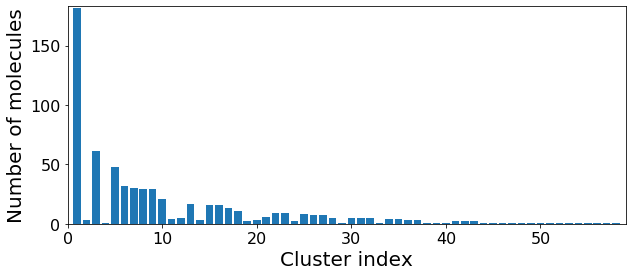

In [36]:
# Plot the size of the clusters
fig = plt.figure(1, figsize=(10, 4))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('Number of molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.show()

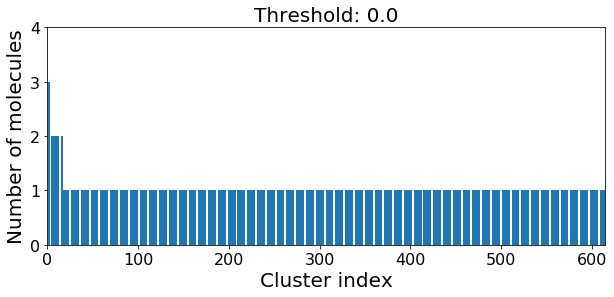

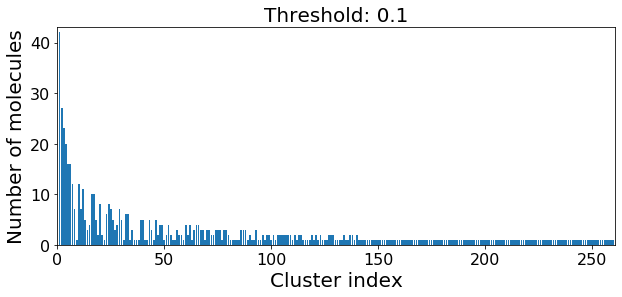

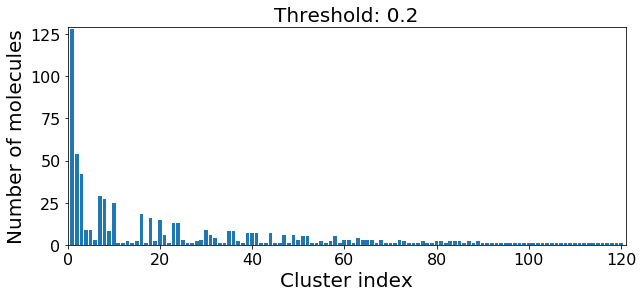

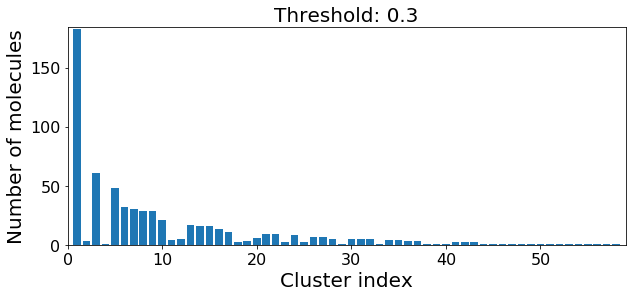

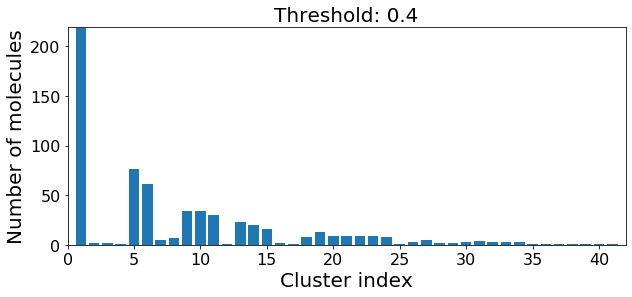

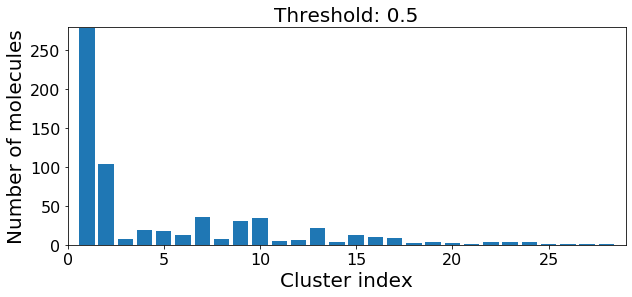

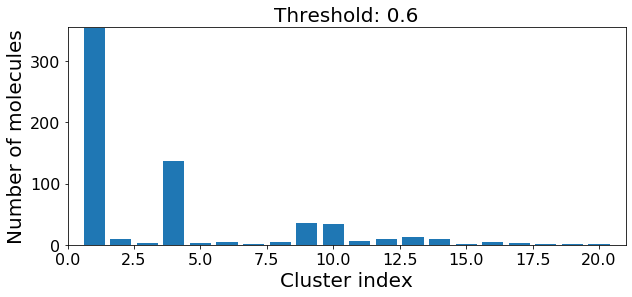

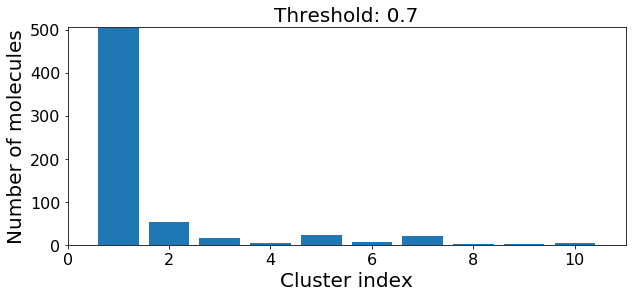

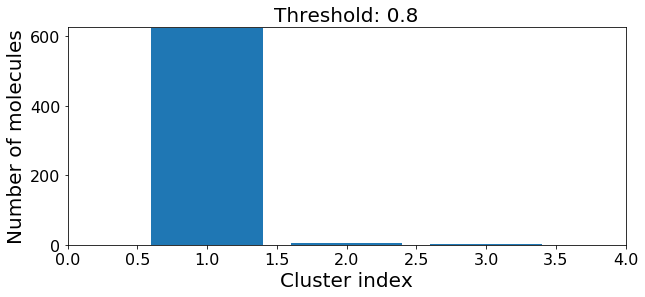

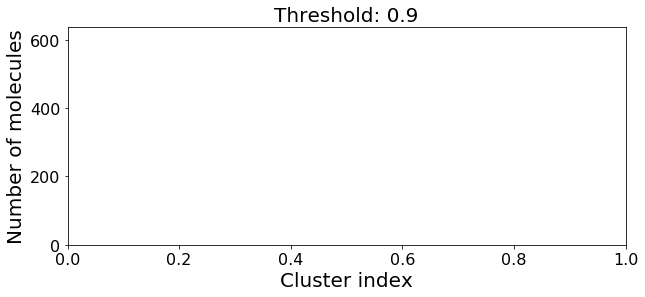

In [37]:
for i in numpy.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fingerprints,cutoff=i)
    fig = plt.figure(1, figsize=(10, 4))
    plt1 = plt.subplot(111)
    plt.axis([0, len(clusters), 0, len(clusters[0])+1])
    plt.xlabel('Cluster index', fontsize=20)
    plt.ylabel('Number of molecules', fontsize=20)
    plt.tick_params(labelsize=16)
    plt.title('Threshold: '+str('%3.1f' %i), fontsize=20)
    plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
    plt.show()

Number of clusters 121 from 635 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 128
Similarity between two random points in same cluster 0.90
Similarity between two random points in different cluster 0.46


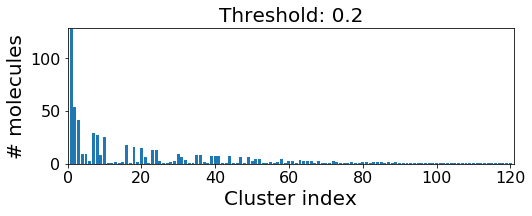

In [65]:
dist_co = 0.2
clusters = ClusterFps(fingerprints,cutoff=dist_co)

# Plot the size of the clusters - save plot
fig = plt.figure(1, figsize=(8, 2.5))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('# molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.title('Threshold: '+str('%3.1f' %dist_co), fontsize=20)
plt.savefig("GSKmol_cluster_dist_cutoff_%4.2f.png" %dist_co, dpi=300, bbox_inches="tight", transparent=True)

print('Number of clusters %d from %d molecules at distance cut-off %4.2f' %(len(clusters), len(mols), dist_co))
print('Number of molecules in largest cluster:', len(clusters[0]))
print('Similarity between two random points in same cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[0][1]]))
print('Similarity between two random points in different cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[1][0]]))

Ten molecules from largest cluster:


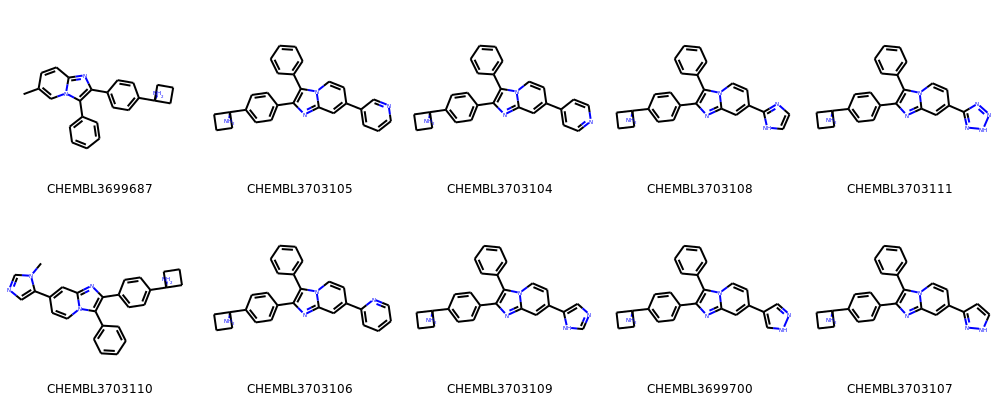

In [66]:
print ('Ten molecules from largest cluster:')
# Draw molecules
Draw.MolsToGridImage([mols[i][0] for i in clusters[0][:10]], 
                     legends=[mols[i][1] for i in clusters[0][:10]], 
                     molsPerRow=5)

In [67]:
# Save molecules from largest cluster for MCS analysis in Talktorial 9
w = Chem.SDWriter('GSKmol_molSet_largestCluster.sdf')

# Prepare data
tmp_mols=[]
for i in clusters[0]:
    tmp = mols[i][0]
    tmp.SetProp("_Name",mols[i][1])
    tmp_mols.append(tmp)  

# Write data
for m in tmp_mols: w.write(m)

Ten molecules from second largest cluster:


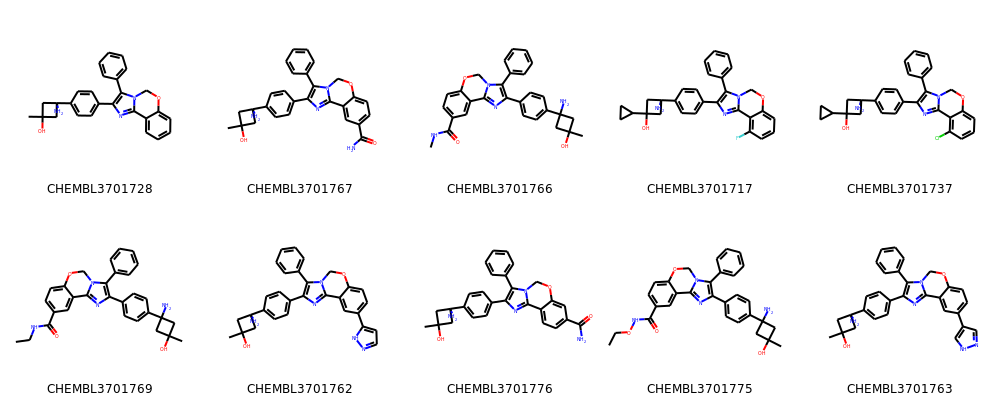

In [68]:
print ('Ten molecules from second largest cluster:')
# Draw molecules
Draw.MolsToGridImage([mols[i][0] for i in clusters[1][:10]], 
                     legends=[mols[i][1] for i in clusters[1][:10]], 
                     molsPerRow=5)

Ten molecules from first 10 clusters:


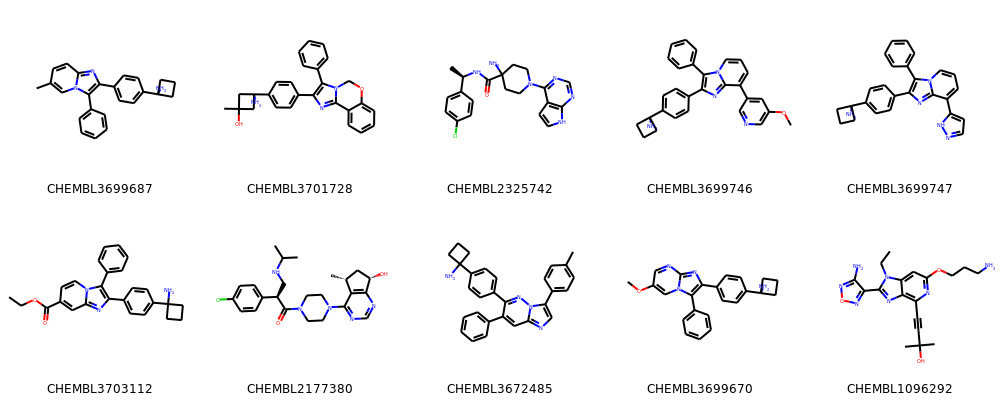

In [69]:
print ('Ten molecules from first 10 clusters:')
# Draw molecules
Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(10)], 
                     legends=[mols[clusters[i][0]][1] for i in range(10)], 
                     molsPerRow=5)

In [70]:
# Generate image
img = Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(0,3)],
                     legends=["Cluster "+str(i) for i in range(1,4)],
                     subImgSize=(200,200), useSVG=True)

# Get SVG data
molsvg = img.data

# Replace non-transparent to transparent background and set font size
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0");
molsvg = molsvg.replace("12px", "20px");

# Save altered SVG data to file
f = open("GSKmol_cluster_representatives.svg", "w")
f.write(molsvg)
f.close()

<b>Intra-cluster Tanimoto similarities</b>

In [71]:
# Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster
def IntraTanimoto(fps_clusters):
    intra_similarity =[]
    # Calculate intra similarity per cluster
    for k in range(0,len(fps_clusters)):
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1-x for x in Tanimoto_distance_matrix(fps_clusters[k])])
    return intra_similarity

In [72]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster=[]
for c in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(mols[i][0]) for i in c])
# Compute intra-cluster similarity 
intra_sim = IntraTanimoto(mol_fps_per_cluster)

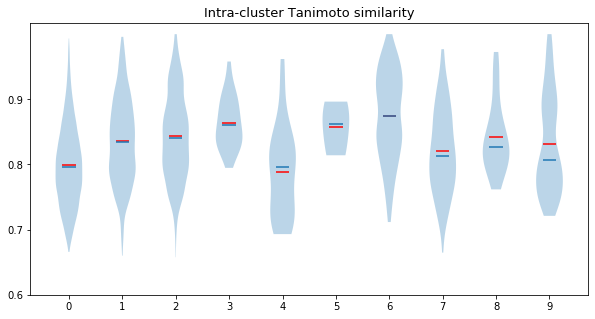

In [73]:
# Violin plot with intra-cluster similarity
pos = list(range(10))
labels = pos
plt.figure(1, figsize=(10, 5))
ax = plt.subplot(111)
r = plt.violinplot(intra_sim, pos, showmeans=True, showmedians=True, showextrema=False)
ax.set_xticks(pos)
ax.set_xticklabels(labels)
ax.set_yticks(numpy.arange(0.6, 1., 0.1))
ax.set_title('Intra-cluster Tanimoto similarity', fontsize=13)
r['cmeans'].set_color('red')
# mean=red, median=blue

<b>STUCK ABOVE</b>

<b>Compound picking:</b>

In [74]:
# Get the cluster center of each cluster (first molecule in each cluster)
clus_center = [mols[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print('Number of cluster centers: ', len(clus_center))

Number of cluster centers:  121


In [75]:
# Sort the molecules within a cluster based on their similarity 
# to the cluster center and sort the clusters based on their size
clusters_sort = []
for c in clusters:
    if len(c) < 2: continue # Singletons
    else:
        # Compute fingerprints for each cluster element
        fps_clust = [rdkit_gen.GetFingerprint(mols[i][0]) for i in c]
        # Similarity of all cluster members to the cluster center
        simils = DataStructs.BulkTanimotoSimilarity(fps_clust[0],fps_clust[1:])
        # Add index of the molecule to its similarity (centroid excluded!)
        simils = [(s,index) for s,index in zip(simils, c[1:])]
        # Sort in descending order by similarity
        simils.sort(reverse=True)
        # Save cluster size and index of molecules in clusters_sort
        clusters_sort.append((len(simils), [i for s,i in simils]))
        # Sort in descending order by cluster size
        clusters_sort.sort(reverse=True)

In [76]:
# Count selected molecules, pick cluster centers first
sel_molecules = clus_center.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
diff = 1000 - len(sel_molecules)
while diff > 0  and index < len(clusters_sort):
    # Take indices of sorted clusters
    tmp_cluster = clusters_sort[index][1]
    # If the first cluster is > 10 big then take exactly 10 compounds
    if clusters_sort[index][0] > 10:
        num_compounds = 10
    # If smaller, take half of the molecules
    else:
        num_compounds = int(0.5*len(c))+1
    if num_compounds > diff: 
        num_compounds = diff
    # Write picked molecules and their structures into list of lists called picked_fps
    sel_molecules += [mols[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    diff = 1000 - len(sel_molecules)
print('# Selected molecules: '+str(len(sel_molecules)))

# Selected molecules: 277


In [77]:
# Reuse old dataset
sampled_mols = mols.copy()

In [78]:
# Helper function for time computation
def MeasureRuntime(sampled_mols):
    start_time = time.time()
    sampled_fingerprints = [rdkit_gen.GetFingerprint(m) for m,idx in sampled_mols]

    # Run the clustering with the dataset
    sampled_clusters = ClusterFps(sampled_fingerprints,cutoff=0.3)
    return(time.time() - start_time)

In [79]:
dsize=[100, 500, 1000, 2000, 4000, 6000, 8000, 10000] 
runtimes=[]
# Take random samples with replacement
for s in dsize:
    tmp_set = [sampled_mols[i] for i in sorted(numpy.random.choice(range(len(sampled_mols)), size=s))]
    tmp_t= MeasureRuntime(tmp_set)
    print('Dataset size %d, time %4.2f seconds' %(s, tmp_t))
    runtimes.append(tmp_t)

Dataset size 100, time 0.05 seconds
Dataset size 500, time 0.27 seconds
Dataset size 1000, time 0.59 seconds
Dataset size 2000, time 1.37 seconds
Dataset size 4000, time 3.61 seconds
Dataset size 6000, time 6.69 seconds
Dataset size 8000, time 10.55 seconds
Dataset size 10000, time 15.17 seconds


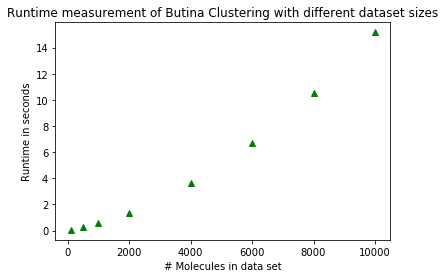

In [80]:
plt.plot(dsize, runtimes, 'g^')
plt.title('Runtime measurement of Butina Clustering with different dataset sizes')
plt.xlabel('# Molecules in data set')
plt.ylabel('Runtime in seconds')
plt.show()